In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.metrics import brier_score_loss
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.calibration import CalibratedClassifierCV
from scipy import ndimage
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import gzip
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd

In [2]:
def read_image_file(filename, images):
    width = 28
    height = 28
    N = images

    f = gzip.open(filename, 'r')
    f.read(16) # skip preamble, 16 bytes
    buffer = f.read(width * height * N) # read in "N" images as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    data = data.reshape(N, width, height, 1) # reshape to Nx28x28x1 (only 1 color channel, b/w)
    f.close()

    return data

def read_label_file(filename, labels):
    N = labels
    
    f = gzip.open(filename, 'r')
    f.read(8) # skip preamble, 8 bytes
    buffer = f.read(N) # read in "N" labels as binary data
    data = np.frombuffer(buffer, dtype='uint8') # convert binary data to integers : 0 - 255
    f.close()
    
    return data

In [3]:
X_train = read_image_file('train-images-idx3-ubyte.gz', 60_000)
y_train = read_label_file('train-labels-idx1-ubyte.gz', 60_000)
X_test = read_image_file('t10k-images-idx3-ubyte.gz', 10_000)
y_test = read_label_file('t10k-labels-idx1-ubyte.gz', 10_000)

X_train = X_train.reshape(60_000, 28*28)
X_test = X_test.reshape(10_000, 28*28)

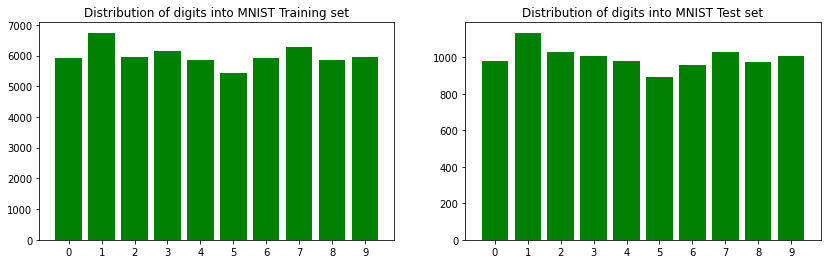

In [20]:
digit_cnt_tr = np.zeros(10)
for item in y_train:
    digit_cnt_tr[item] += 1

digit_cnt_te = np.zeros(10)
for item in y_test:
    digit_cnt_te[item] += 1

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

ax1.bar(np.arange(len(digit_cnt_tr)), digit_cnt_tr, color='green')
ax1.set_xticks(np.arange(len(digit_cnt_tr)))
ax1.set_title('Distribution of digits into MNIST Training set')

ax2.bar(np.arange(len(digit_cnt_te)), digit_cnt_te, color='green')
ax2.set_xticks(np.arange(len(digit_cnt_te)))
ax2.set_title('Distribution of digits into MNIST Test set')

plt.show()



MEAN GRAPH


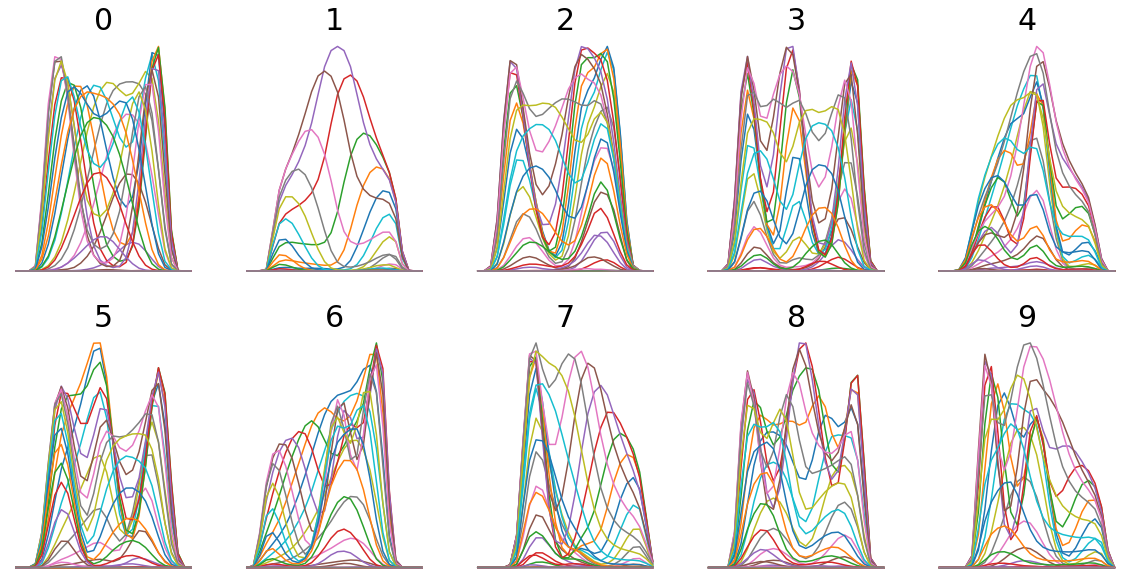

In [25]:
print('\n\nMEAN GRAPH')
X = X_train
y = y_train
u = np.zeros((10, 784))
plt.figure(figsize=(20,10))
for i in range(10):
    u[i] = np.mean(X[y==i], 0)
    plt.subplot(2,5,i+1)
    plt.plot(u[i].reshape(28, 28))
    plt.axis('off')
    plt.title(str(i), fontsize=30)
plt.show()

Train time elapsed: 0.45s
Test time elapsed: 0.08s
Training accuracy: 100.00%
Testing accuracy: 87.55%
                  === Classification Report ===
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.95      0.96      0.95      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.86      0.84      1010
           4       0.86      0.87      0.86       982
           5       0.84      0.83      0.83       892
           6       0.90      0.88      0.89       958
           7       0.92      0.89      0.91      1028
           8       0.82      0.80      0.81       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.88      0.88      0.88     10000


Accuracy of Classifier on Test Images:  0.8755


,Accuracy
Digit 0,93.469388
Digit 1,96.299559
Digit 2,85.949612
Digit 3,85.544554
Digit 4,86.863544
Digit 5,83.071749
Digit 6,88.413361
Digit 7,89.299611
Digit 8,80.184805
Digit 9,84.737364


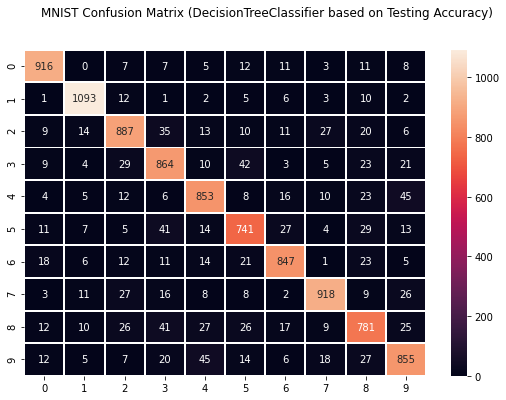

In [19]:
bnb=DecisionTreeClassifier()
bnb.fit(X_train, y_train)

t0 = time.time()
bnb_tre=bnb.predict(X_train)
train_accuracy=bnb.score(X_train,y_train)
print('Train time elapsed: %.2fs' % (time.time()-t0))

t1 = time.time()
bnb_pre=bnb.predict(X_test)
test_accuracy=bnb.score(X_test,y_test)
print('Test time elapsed: %.2fs' % (time.time()-t1))

print('Training accuracy: %0.2f%%' % (train_accuracy*100))
print('Testing accuracy: %0.2f%%' % (test_accuracy*100))


cm = metrics.confusion_matrix(y_test, bnb_pre)
plt.figure(figsize=(9, 6))
sns.heatmap(cm, linewidths=.9, annot=True, fmt='g')
plt.suptitle('MNIST Confusion Matrix (DecisionTreeClassifier based on Testing Accuracy)')

print('                  === Classification Report ===')
print(metrics.classification_report(y_test, bnb_pre))

acc = metrics.accuracy_score(y_test,bnb_pre)
print('\nAccuracy of Classifier on Test Images: ',acc)

unique, counts = np.unique(y_test, return_counts=True)
counts=counts.tolist()

a=cm.diagonal()
acc={}
# The accuracy is found using unique digits and their respective count from test set and comparing that with confusion matrix
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
for i in range(0,len(a)):
    e=[]
    e.append((a[i]/counts[i])*100)
    acc[i]=e
column=[]
for i in range(0,10):
    column.append('Digit %d'%i)    
acc=pd.DataFrame(acc)
acc.columns=column
acc=acc.T
acc.columns=['Accuracy']
acc


In [150]:
test_accuracy = []
t0 = time.time()
depth_range = 10
for i in range(1, depth_range):
    ti = time.time()
    clf_dt_depth = DecisionTreeClassifier(max_depth=i)
    clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    test_pred_dt = clf_dt_depth.predict(X_test.reshape(-1,28*28))
    print(test_accuracy)
    test_accuracy.append(accuracy_score(y_test, test_pred_dt))
    print('Depth: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
print(clf_dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

[]
Depth: 1/10 and took 2.08s
[0.1994]
Depth: 2/10 and took 3.51s
[0.1994, 0.3447]
Depth: 3/10 and took 4.63s
[0.1994, 0.3447, 0.4953]
Depth: 4/10 and took 6.21s
[0.1994, 0.3447, 0.4953, 0.5957]
Depth: 5/10 and took 7.63s
[0.1994, 0.3447, 0.4953, 0.5957, 0.6747]
Depth: 6/10 and took 9.09s
[0.1994, 0.3447, 0.4953, 0.5957, 0.6747, 0.7416]
Depth: 7/10 and took 10.20s
[0.1994, 0.3447, 0.4953, 0.5957, 0.6747, 0.7416, 0.7853]
Depth: 8/10 and took 11.37s
[0.1994, 0.3447, 0.4953, 0.5957, 0.6747, 0.7416, 0.7853, 0.8185]
Depth: 9/10 and took 12.16s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Time elapsed: 78.46s


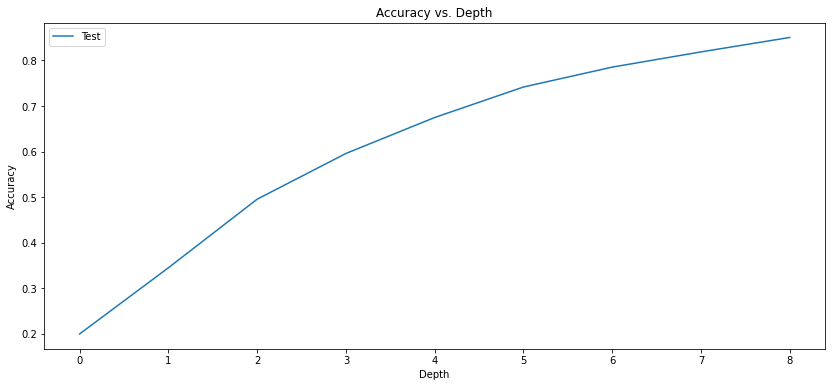

In [149]:
plt.figure(figsize=(14,6))
plt.title('Accuracy vs. Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.plot(test_accuracy)
plt.legend(['Test'])
plt.show()

In [126]:
print('Highest test accuracy: {} at depth of {}'
      .format(max(test_accuracy), test_accuracy.index(max(test_accuracy))+1))


Highest test accuracy: 0.8503 at depth of 9


In [127]:
clf_dt_best_depth = DecisionTreeClassifier(max_depth=test_accuracy.index(max(test_accuracy))+1)
clf_dt_best_depth.fit(X_train.reshape(-1,28*28), y_train)
pred_dt_best_depth = clf_dt_best_depth.predict(X_test.reshape(-1,28*28))

Text(0.5, 1.0, 'Confusion Matrix at Best Depth of 9')

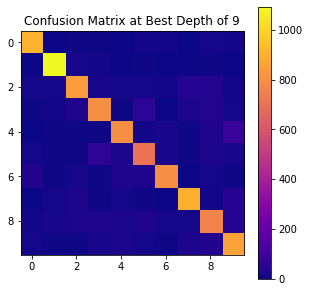

In [128]:
cnf_matrix_bd = confusion_matrix(y_test,pred_dt_best_depth)
plt.figure(figsize=(5,5))
plt.imshow(cnf_matrix_bd, cmap='plasma')
plt.colorbar()
plt.title("Confusion Matrix at Best Depth of {}".format(test_accuracy.index(max(test_accuracy))+1))

In [129]:
    print(classification_report(y_test,pred_dt_best_depth))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       980
           1       0.93      0.96      0.95      1135
           2       0.87      0.82      0.84      1032
           3       0.83      0.80      0.81      1010
           4       0.85      0.82      0.83       982
           5       0.80      0.80      0.80       892
           6       0.90      0.84      0.87       958
           7       0.88      0.88      0.88      1028
           8       0.77      0.79      0.78       974
           9       0.77      0.85      0.81      1009

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [130]:
correct_indices_d = np.nonzero(pred_dt_best_depth == y_test)[0]
incorrect_indices_d = np.nonzero(pred_dt_best_depth != y_test)[0]

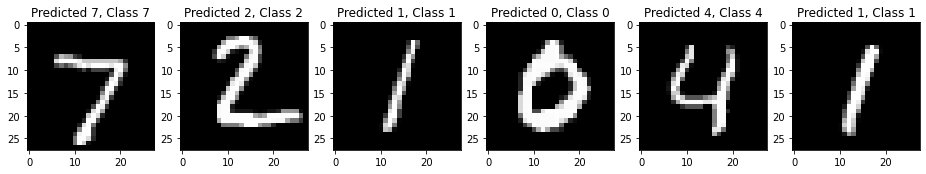

In [131]:
num_figures = 6
plt.figure(figsize=(16,8))
for i, correct in enumerate(correct_indices_d[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pred_dt_best_depth[correct], y_test[correct]))

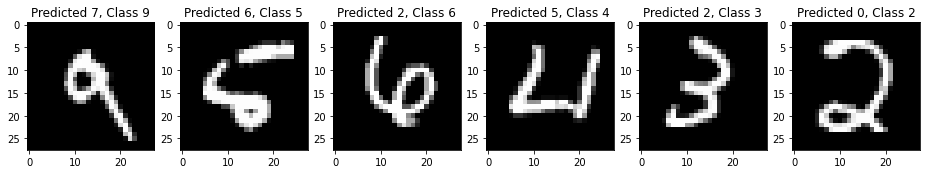

In [132]:
num_figures = 6
plt.figure(figsize=(16,8))
for i, incorrect in enumerate(incorrect_indices_d[:num_figures]):
    plt.subplot(1,num_figures,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(pred_dt_best_depth[incorrect], y_test[incorrect]))

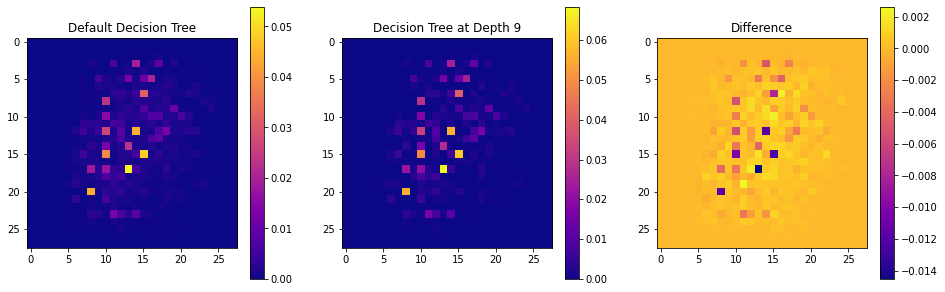

In [133]:
importances_dt = bnb.feature_importances_
importances_depth = clf_dt_best_depth.feature_importances_

heat_dt = importances_dt.reshape(28,28)
heat_depth = importances_depth.reshape(28,28)
heat_dif = heat_dt-heat_depth
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.title('Default Decision Tree')
plt.imshow(heat_dt, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Decision Tree at Depth {}'.format(test_accuracy.index(max(test_accuracy))+1))
plt.imshow(heat_depth, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Difference')
plt.imshow(heat_dif, cmap='plasma', interpolation='nearest')
plt.colorbar()
plt.show()

In [134]:
add_in_pixels = False

In [135]:
def add_custom_features(features):
    new_features = []
    for feature in features:
        if add_in_pixels:
            tmp_feature = feature.reshape(28*28)
            tmp_feature = tmp_feature.tolist()
        else:
            tmp_feature = []
        tmp_feature.append(np.mean(feature))  # Find the average pixel value
        tmp_feature.append(np.count_nonzero(feature.tolist()))  # Count non-zero values
        center = ndimage.measurements.center_of_mass(feature.reshape(28,28))
        tmp_feature.append(np.sum(center))  # Sum of center of mass
        tmp_feature.append(np.mean(center))  # Mean of center of mass
        new_features.append(tmp_feature)
    return np.array(new_features)

In [136]:
from scipy import ndimage
X_train_new = add_custom_features(X_train)
X_test_new = add_custom_features(X_test)

In [137]:
t0 = time.time()
clf_dt_new = DecisionTreeClassifier()
clf_dt_new.fit(X_train_new, y_train)
print('Time elapsed: %.2fs' % (time.time()-t0))

Time elapsed: 0.54s


In [138]:
pred_dt_new = clf_dt_new.predict(X_test_new)
print('Predicted', len(bnb_pre), 'digits with accuracy:', accuracy_score(y_test, pred_dt_new))

Predicted 10000 digits with accuracy: 0.216


In [139]:
if add_in_pixels:
    importances_dt_new = clf_dt_new.feature_importances_[784:]
else:
    importances_dt_new = clf_dt_new.feature_importances_
print('Importanes: {}'.format(importances_dt_new))

Importanes: [0.35252021 0.23462572 0.20500715 0.20784693]


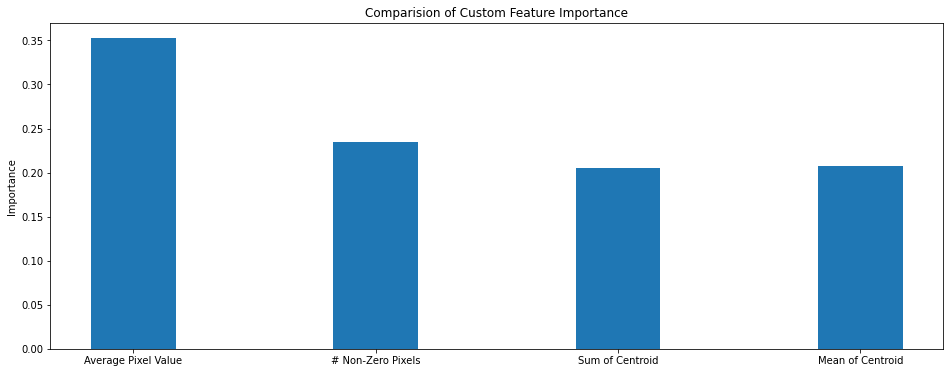

In [140]:
plt.figure(figsize=(16,6))
ind = np.arange(len(importances_dt_new))
plt.bar(ind, importances_dt_new, 0.35)
plt.title('Comparision of Custom Feature Importance')
plt.ylabel('Importance')
plt.xticks(ind, ('Average Pixel Value', '# Non-Zero Pixels', 'Sum of Centroid', 'Mean of Centroid'))
plt.show()

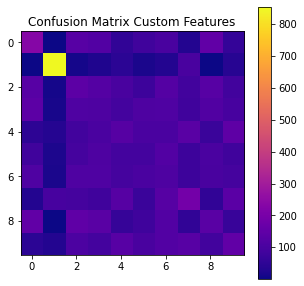

In [141]:
cnf_matrix_custom = confusion_matrix(y_test,pred_dt_new)
plt.figure(figsize=(5,5))
plt.imshow(cnf_matrix_custom, cmap='plasma')
plt.colorbar()
plt.title("Confusion Matrix Custom Features")
plt.show()

In [142]:
print(classification_report(y_test,pred_dt_new))

              precision    recall  f1-score   support

           0       0.24      0.24      0.24       980
           1       0.78      0.75      0.77      1135
           2       0.14      0.14      0.14      1032
           3       0.11      0.11      0.11      1010
           4       0.14      0.13      0.13       982
           5       0.11      0.10      0.11       892
           6       0.10      0.12      0.11       958
           7       0.20      0.19      0.19      1028
           8       0.14      0.14      0.14       974
           9       0.16      0.15      0.15      1009

    accuracy                           0.22     10000
   macro avg       0.21      0.21      0.21     10000
weighted avg       0.22      0.22      0.22     10000



Train Size: 60000 Test_Size: 10000
[0.8772]
Train Size: 1/10 and took 32.95s
Train Size: 30000 Test_Size: 10000
[0.8772, 0.8505]
Train Size: 2/10 and took 12.02s
Train Size: 15000 Test_Size: 10000
[0.8772, 0.8505, 0.8291]
Train Size: 3/10 and took 5.15s
Train Size: 7500 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985]
Train Size: 4/10 and took 1.98s
Train Size: 3750 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985, 0.7659]
Train Size: 5/10 and took 0.77s
Train Size: 1875 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985, 0.7659, 0.7084]
Train Size: 6/10 and took 0.35s
Train Size: 937 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985, 0.7659, 0.7084, 0.6329]
Train Size: 7/10 and took 0.20s
Train Size: 468 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985, 0.7659, 0.7084, 0.6329, 0.5505]
Train Size: 8/10 and took 0.11s
Train Size: 234 Test_Size: 10000
[0.8772, 0.8505, 0.8291, 0.7985, 0.7659, 0.7084, 0.6329, 0.5505, 0.5356]
Train Size: 9/10 and took 0.08s
DecisionTreeClassifier(ccp_alpha=0.

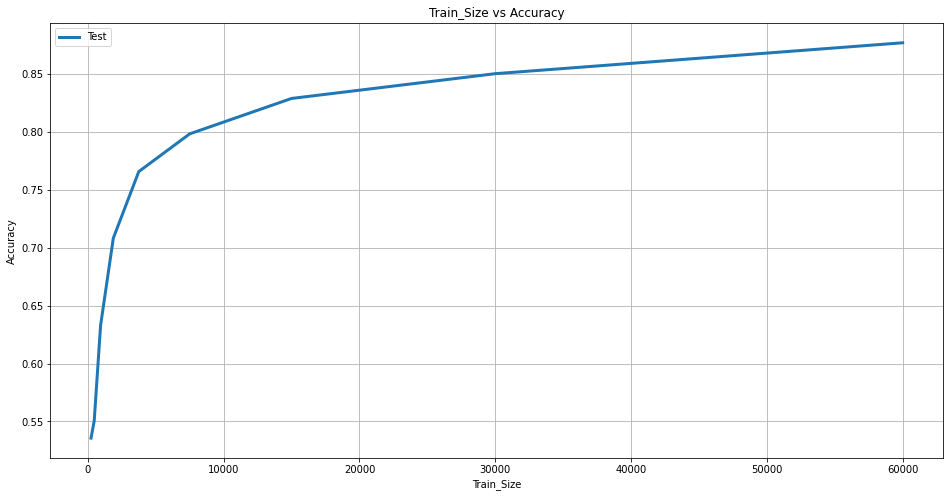

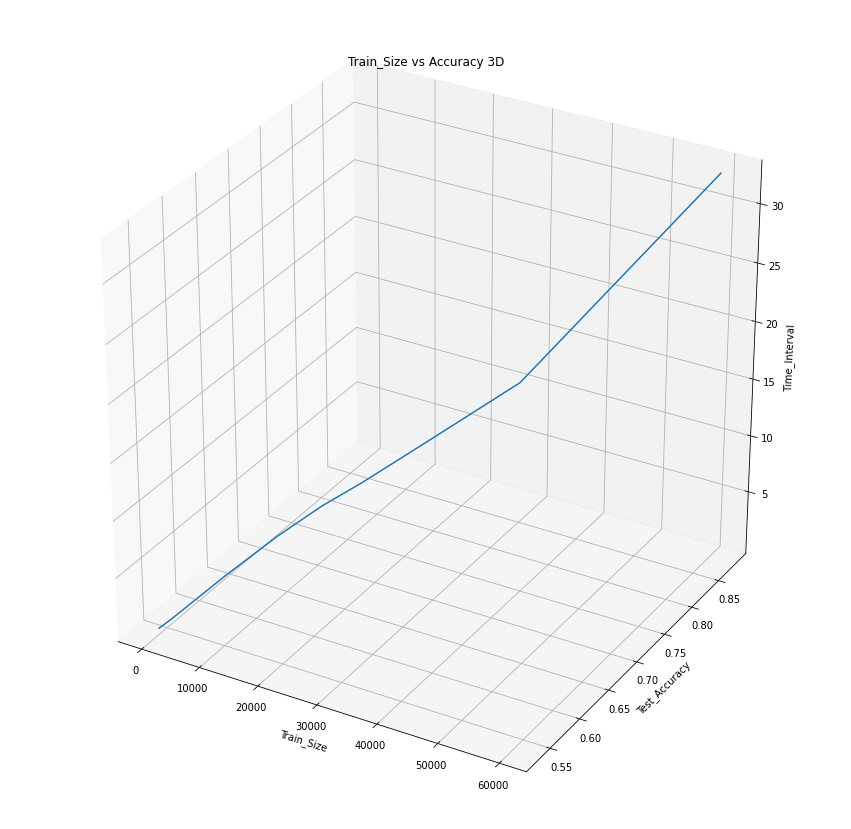

In [5]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
train_size = []
time_interval = []
depth_range = 10
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    train_size.append(Tn_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    dt_depth = DecisionTreeClassifier()
    
    dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tn_S = Tn_S/2 
    Tn_S = int(Tn_S)
    time_interval.append(time.time()-ti)
print(dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Train_Size vs Accuracy')
plt.xlabel('Train_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(train_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Train_Size vs Accuracy 3D')
ax.set_xlabel('Train_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(train_size,test_accuracy,time_interval)

Train Size: 60000 Test_Size: 10000
[0.8764]
Train Size: 1/6 and took 34.05s
Train Size: 60000 Test_Size: 5000
[0.8764, 0.8528]
Train Size: 2/6 and took 32.49s
Train Size: 60000 Test_Size: 2500
[0.8764, 0.8528, 0.858]
Train Size: 3/6 and took 32.87s
Train Size: 60000 Test_Size: 1250
[0.8764, 0.8528, 0.858, 0.8696]
Train Size: 4/6 and took 34.00s
Train Size: 60000 Test_Size: 625
[0.8764, 0.8528, 0.858, 0.8696, 0.8624]
Train Size: 5/6 and took 33.11s
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Time elapsed: 198.63s


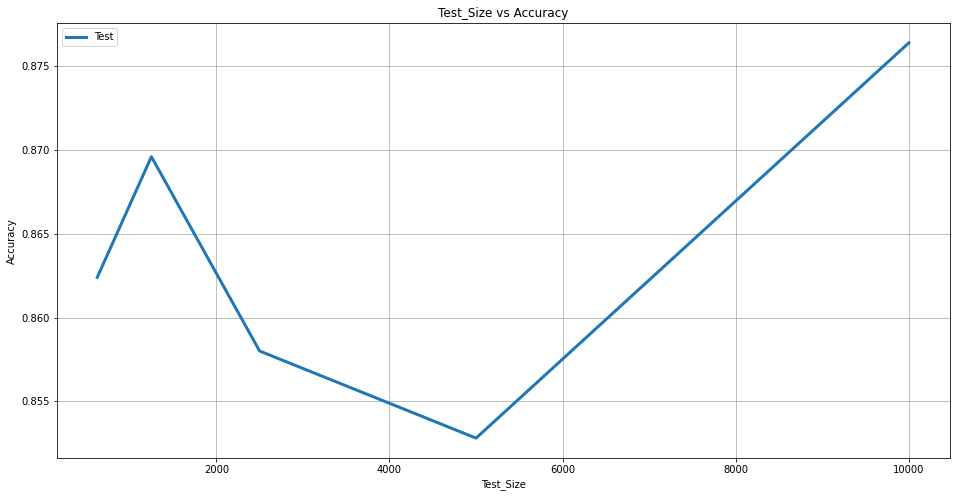

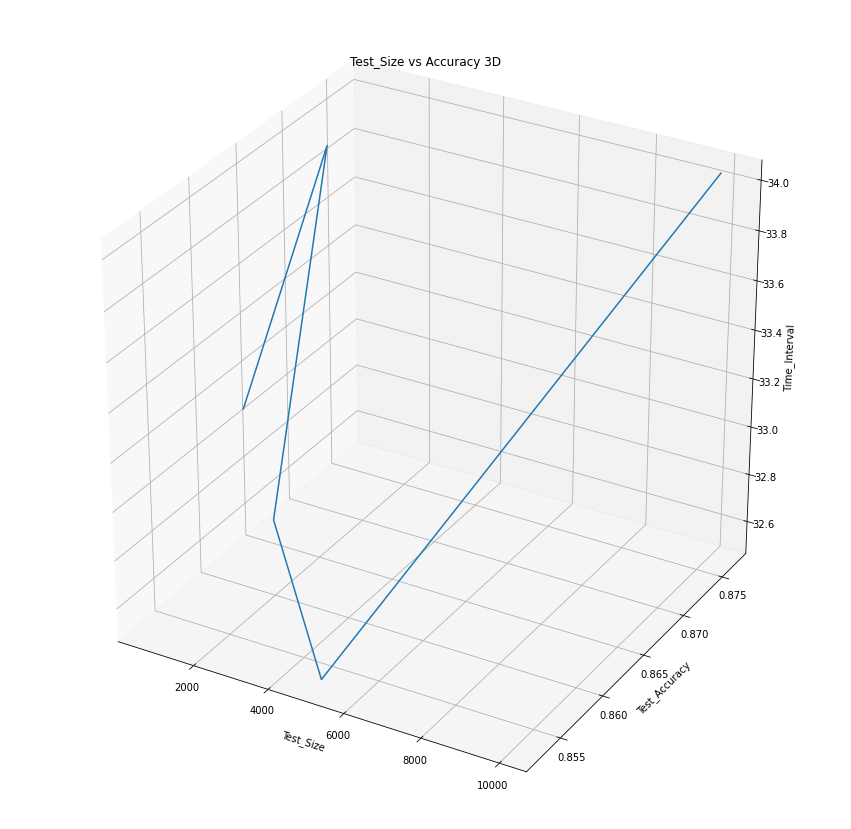

In [6]:
Tn_S = 60_000
Tt_S = 10_000 

test_accuracy = []
test_size = []
time_interval = []
depth_range = 6
t0 = time.time()
for i in range(1, depth_range):
    ti = time.time()
    test_size.append(Tt_S)
    print('Train Size: ' + str(Tn_S) + ' ' + 'Test_Size: ' + str(Tt_S))
    X_train = read_image_file('train-images-idx3-ubyte.gz', Tn_S)
    y_train = read_label_file('train-labels-idx1-ubyte.gz', Tn_S)
    X_test = read_image_file('t10k-images-idx3-ubyte.gz', Tt_S)
    y_test = read_label_file('t10k-labels-idx1-ubyte.gz', Tt_S)
    
    dt_depth = DecisionTreeClassifier()
    
    dt_depth.fit(X_train.reshape(-1,28*28), y_train)
    
    test_pred_dt = dt_depth.predict(X_test.reshape(-1,28*28))

    test_accuracy.append(metrics.accuracy_score(y_test, test_pred_dt))
    print(test_accuracy)
    print('Train Size: {}/{} and took %.2fs'.format(i,depth_range) % (time.time()-ti))
    Tt_S = Tt_S/2 
    Tt_S = int(Tt_S)
    time_interval.append(time.time()-ti)
print(dt_depth.fit(X_train.reshape(-1,28*28), y_train))
print('Time elapsed: %.2fs' % (time.time()-t0))

plt.figure(figsize=(16,8))
plt.title('Test_Size vs Accuracy')
plt.xlabel('Test_Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.plot(test_size,test_accuracy, lw=3)
plt.legend(['Test'])
plt.show()

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Test_Size vs Accuracy 3D')
ax.set_xlabel('Test_Size')
ax.set_ylabel('Test_Accuracy')
ax.set_zlabel('Time_Interval')
ax.plot3D(test_size,test_accuracy,time_interval)